# Example of creating a history plot given a device id for check standard
Written by AWS 05/2016
1. import new file
2. find device id / system_id
3. open history file
4. average values for history* remember error propagation
5. show both on one plot

In [1]:
# imports from standard library
# import of needed libraries
import os
import re
import datetime
import pandas
import sqlite3
import odo
from types import *
from pyMeasure import *
import numpy as np
import matplotlib.pyplot as plt

The module smithplot was not found,please put it on the python path


In [2]:
# Data sources, to be replaced as project_files in Django
TWO_PORT_NR_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Two_Port_NR_Check_Standard.csv"
COMBINED_ONE_PORT_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Combined_One_Port_Check_Standard.csv"
COMBINED_TWO_PORT_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Combined_Two_Port_Check_Standard.csv"
COMBINED_POWER_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Combined_Power_Check_Standard.csv"
ONE_PORT_CALREP_CSV=r"C:\Share\Converted_DUT\One_Port_DUT.csv"
TWO_PORT_CALREP_CSV=r"C:\Share\Converted_DUT\Two_Port_DUT.csv"
POWER_3TERM_CALREP_CSV=r"C:\Share\Converted_DUT\Power_3Term_DUT.csv"
POWER_4TERM_CALREP_CSV=r"C:\Share\Converted_DUT\Power_4Term_DUT.csv"

In [3]:
os.chdir(TESTS_DIRECTORY)
test_file='CTN208.A1_011613'
file_model=sparameter_power_type(test_file)

<IPython.core.display.Javascript object>


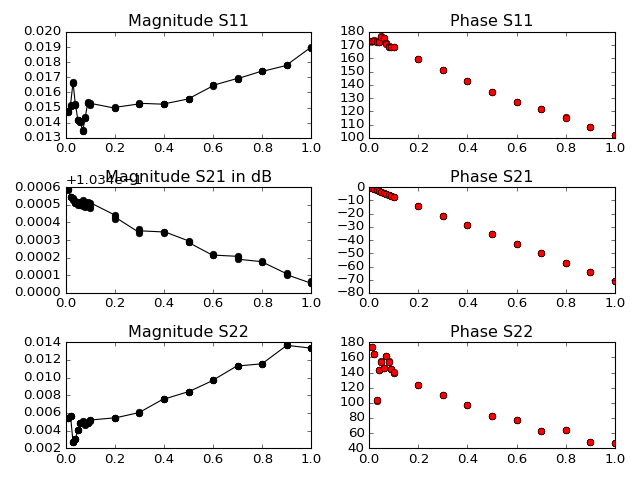

In [4]:
%matplotlib notebook
model=globals()[file_model]
table=model(test_file)
# need to fix the show() method to reflect conversion of S21
table.show()


In [5]:
two_port_history=pandas.read_csv(COMBINED_TWO_PORT_CHKSTD_CSV)

C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (10,11,12,16,18,19,20,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [72]:
device_id=table.metadata["Device_Id"]
system_id=table.metadata["System_Id"]

In [73]:
device_history=two_port_history[two_port_history["Device_Id"]==device_id]
#device_history=device_history[device_history["System_Id"]==system_id]

In [74]:
device_history["System_Id"].unique()
print device_id

C07208


In [75]:
print table.metadata["Device_Description"]


20 db ck std


<IPython.core.display.Javascript object>


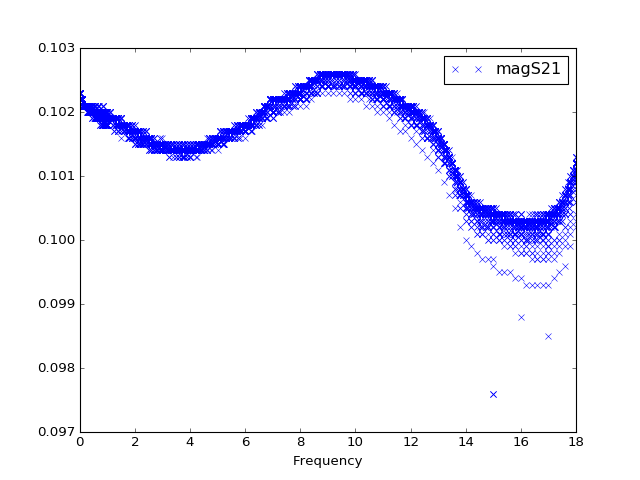

In [76]:
device_history.plot(x="Frequency",y="magS21",style='x')

In [77]:
def two_port_mean(device_id,system_id=None,history_data_frame=None):
    """Given a Device_Id and a pandas data frame of the history creates a mean data_frame"""
    device_history=history_data_frame[history_data_frame["Device_Id"]==device_id]
    if system_id is not None:
        device_history=device_history[device_history["System_Id"]==system_id]
    column_names=['Frequency','magS11','argS11','magS21','argS21','magS22','argS22']
    unique_frequency_list=device_history["Frequency"].unique()
    mean_array=[]
    for index,freq in enumerate(unique_frequency_list):
        row=[]
        for column in column_names:
            values=np.mean(device_history[device_history["Frequency"]==unique_frequency_list[index]][column].as_matrix())
            #print values
            mean_value=np.mean(values)
            row.append(mean_value)
        mean_array.append(row)
    mean_frame=pandas.DataFrame(mean_array,columns=column_names)
    return mean_frame
        

In [78]:
mean_frame=two_port_mean(device_id,system_id,two_port_history)

In [79]:
def two_port_comparision_plot(two_port_raw,mean_frame):
    """Creates a comparision plot given a TwoPortRawModel object and a pandas.DataFrame mean frame"""
    fig, axes = plt.subplots(nrows=3, ncols=2)
    measurement_date=two_port_raw.metadata["Measurement_Date"]
    ax0, ax1, ax2, ax3, ax4, ax5 = axes.flat
    ax0.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column('magS11'),'k-o',label=measurement_date)
    ax0.plot(mean_frame['Frequency'].tolist(),mean_frame['magS11'].tolist(),'gs',label='Mean')
    ax0.set_title('Magnitude S11')
    ax1.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column('argS11'),'ro',label=measurement_date)
    ax1.plot(mean_frame['Frequency'].tolist(),mean_frame['argS11'].tolist(),'gs',label='Mean')
    ax1.set_title('Phase S11')
    ax2.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column('magS21'),'k-o',label=measurement_date)
    #ax2.plot(mean_frame['Frequency'].tolist(),mean_frame['magS21'].tolist(),'gs',label='Mean')
    ax2.plot(mean_frame['Frequency'].tolist()
             ,mean_frame['magS21'].tolist(),'gs',label='Mean')
    ax2.set_title('Magnitude S21')
    ax3.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column('argS21'),'ro',label=measurement_date)
    ax3.plot(mean_frame['Frequency'].tolist(),mean_frame['argS21'].tolist(),'gs',label='Mean')
    ax3.set_title('Phase S21')
    ax4.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column('magS22'),'k-o',label=measurement_date)
    ax4.plot(mean_frame['Frequency'].tolist(),mean_frame['magS22'].tolist(),'gs',label='Mean')
    ax4.set_title('Magnitude S22')
    ax5.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column('argS22'),'ro',label=measurement_date)
    ax5.plot(mean_frame['Frequency'].tolist(),mean_frame['argS22'].tolist(),'gs',label='Mean')
    ax5.set_title('Phase S22')
    plt.tight_layout()
    plt.show()
    

<IPython.core.display.Javascript object>


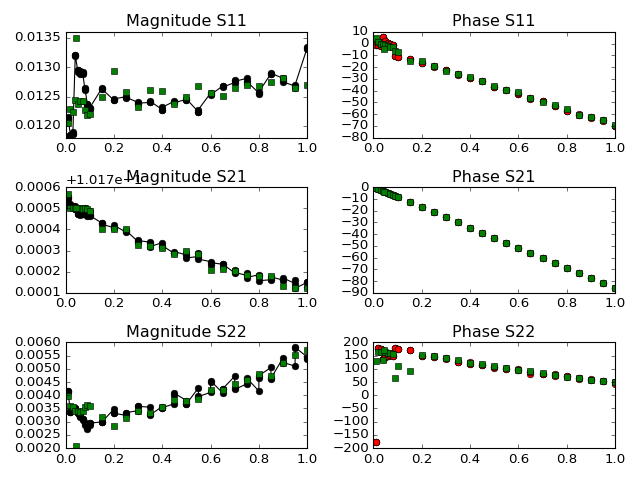

In [80]:
two_port_comparision_plot(table,mean_frame)

device_history["Frequency"].unique()

In [81]:
def two_port_difference(two_port_raw,mean_frame):
    """Creates a difference plot given a two port raw file and a mean plot"""
    difference_list=[]
    for row in two_port_raw.data[:]:
        #print row[0]
        mean_row=mean_frame[abs(mean_frame["Frequency"]-row[0])<abs(.0002)].as_matrix()
        #print mean_row
        mean_row=mean_row[0]
        difference_row=[row[i+2]-mean_row[i] for i in range(1,len(mean_row))]
        difference_row.insert(0,row[0])
        difference_list.append(difference_row)
    return difference_list
        

In [82]:
def two_port_difference_frame(two_port_raw,mean_frame):
    """Creates a difference pandas.DataFrame given a two port raw file and a mean pandas.DataFrame"""
    difference_list=[]
    for row in two_port_raw.data[:]:
        #print row[0]
        mean_row=mean_frame[abs(mean_frame["Frequency"]-row[0])<abs(.01)].as_matrix()
        #print mean_row
        try:
            mean_row=mean_row[0]
            difference_row=[row[i+2]-mean_row[i] for i in range(1,len(mean_row))]
            difference_row.insert(0,row[0])
            difference_list.append(difference_row)
        except:pass
    column_names=['Frequency','magS11','argS11','magS21','argS21','magS22','argS22']
    diff_data_frame=pandas.DataFrame(difference_list,columns=column_names)
    return diff_data_frame

In [17]:
two_port_difference(table,mean_frame)

[[0.01,
  -0.001030936329588018,
  81.746474906367055,
  -5.6760324360083381e-06,
  0.0045333333333333892,
  0.0003050936329588019,
  89.540630337078653],
 [0.01,
  -0.0010009363295880175,
  81.767474906367042,
  -1.2739369880374052e-05,
  -0.0014666666666666162,
  0.0002950936329588023,
  89.71863033707865],
 [0.01,
  -0.00094093632958801819,
  81.87047490636705,
  -5.0774224639033028e-06,
  -0.0054666666666666197,
  0.0002950936329588023,
  89.363630337078661],
 [0.02,
  5.5992063492063537e-05,
  32.391860714285713,
  -2.9660555038502068e-05,
  -0.0011829365079365495,
  0.0012548809523809518,
  50.351912301587291],
 [0.02,
  7.5992063492062722e-05,
  32.481860714285716,
  -2.8344205794977873e-05,
  0.0008170634920634523,
  0.0012448809523809513,
  50.483912301587296],
 [0.02,
  0.00013599206349206375,
  32.354860714285735,
  -2.6190143801035903e-05,
  -0.005182936507936553,
  0.0012448809523809513,
  50.320912301587285],
 [0.03,
  0.0016715957446808514,
  -1.3432425531914873,
  -6.82

In [ ]:
column_names=['Frequency','magS11','argS11','magS21','argS21','magS22','argS22']
diff_data_frame=pandas.DataFrame(two_port_difference(table,mean_frame),columns=column_names)

In [ ]:
fig,ax=plt.subplots(1,1)
diff_data_frame.plot(x="Frequency",y="magS11",style="r-o",ax=ax)
plt.show()

In [83]:
def two_port_comparision_plot_with_residuals(two_port_raw,mean_frame,difference_frame):
    """Creates a comparision plot given a TwoPortRawModel object and a pandas.DataFrame mean frame"""
    fig, axes = plt.subplots(nrows=6, ncols=2, sharex='col')
    measurement_date=two_port_raw.metadata["Measurement_Date"]
    ax0,ax1,diff_ax0,diff_ax1, ax2,ax3, diff_ax2, diff_ax3, ax4,ax5,diff_ax4, diff_ax5 = axes.flat
    diff_axes=[diff_ax0,diff_ax1,diff_ax2,diff_ax3,diff_ax4,diff_ax5]
    compare_axes=[ax0,ax1,ax2,ax3,ax4,ax5]
    column_names=['Frequency','magS11','argS11','magS21','argS21','magS22','argS22']
    for index,ax in enumerate(diff_axes):
        ax.plot(difference_frame['Frequency'].tolist(),difference_frame[column_names[index+1]].tolist(),'r-x')
        #ax.legend_.remove()
    for index, ax in enumerate(compare_axes):
        ax.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column(column_names[index+1]),
                'k-o',label=measurement_date)
        ax.plot(mean_frame['Frequency'].tolist(),mean_frame[column_names[index+1]].tolist(),'gs',label='Mean')
        #ax.set_title(column_names[index+1])
        ax.xaxis.set_visible(False)
        #ax.sharex(diff_axes[index])
    fig.subplots_adjust(hspace=0)
    #plt.tight_layout()
    plt.show()
    

In [92]:
def two_port_comparision_plot_with_residuals(two_port_raw,mean_frame,difference_frame):
    """Creates a comparision plot given a TwoPortRawModel object and a pandas.DataFrame mean frame"""
    fig, axes = plt.subplots(nrows=3, ncols=2, sharex='col',figsize=(8,6),dpi=80)
    measurement_date=two_port_raw.metadata["Measurement_Date"]
    ax0,ax1,ax2,ax3,ax4,ax5 = axes.flat
    compare_axes=[ax0,ax1,ax2,ax3,ax4,ax5]
    diff_axes=[]
    for ax in compare_axes:
        diff_axes.append(ax.twinx())
    #diff_axes=[diff_ax0,diff_ax1,diff_ax2,diff_ax3,diff_ax4,diff_ax5]
    column_names=['Frequency','magS11','argS11','magS21','argS21','magS22','argS22']
    for index,ax in enumerate(diff_axes):
        ax.plot(difference_frame['Frequency'].tolist(),difference_frame[column_names[index+1]].tolist(),'r-x')
        ax.set_ylabel('Difference',color='red')
        if re.search('mag',column_names[index+1]):
            ax.set_ylim(-.02,.02)
        #ax.legend_.remove()
    for index, ax in enumerate(compare_axes):
        ax.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column(column_names[index+1]),
                'k-o',label=measurement_date)
        ax.plot(mean_frame['Frequency'].tolist(),mean_frame[column_names[index+1]].tolist(),'gs',label='Mean')
        ax.set_title(column_names[index+1])
        ax.legend(loc=1,fontsize='8')
        #ax.xaxis.set_visible(False)
        if re.search('arg',column_names[index+1]):
            ax.set_ylabel('Phase(Degrees)',color='green')
        elif re.search('mag',column_names[index+1]):
            ax.set_ylabel(r'|${\Gamma} $|',color='green')
        #ax.sharex(diff_axes[index])
    ax4.set_xlabel('Frequency(GHz)',color='k')
    ax5.set_xlabel('Frequency(GHz)',color='k')
    fig.subplots_adjust(hspace=0)
    fig.suptitle(table.metadata["Device_Id"]+"\n",fontsize=18,fontweight='bold')
    plt.tight_layout()
    plt.show()

In [ ]:
%matplotlib notebook
two_port_comparision_plot_with_residuals(table,mean_frame,diff_data_frame)
matplotlib.rcParams['figure.figsize']=(8.0,6.0)

<IPython.core.display.Javascript object>


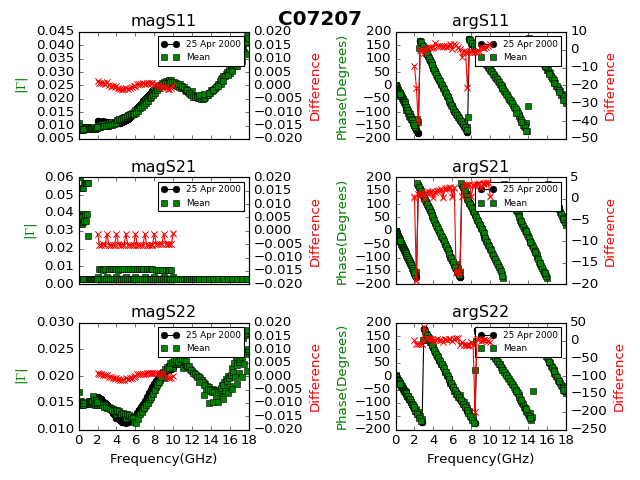

In [107]:
#input_file=r"C:\Share\Ck_Std_raw_ascii\C07207.D1_030298"
input_file=r"C:\Share\Ck_Std_raw_ascii\C07207.D9_042500"
#input_file=r"C:\Share\Ck_Std_raw_ascii\C07208.A10_081507"

file_model=sparameter_power_type(input_file)
model=globals()[file_model]
table=model(input_file)
#print table
if re.search('2-port',table.metadata["Measurement_Type"],re.IGNORECASE):
    history=pandas.read_csv(COMBINED_TWO_PORT_CHKSTD_CSV)
#table.metadata["System_Id"]
mean_frame=two_port_mean(table.metadata["Device_Id"],None,history)
#print mean_frame
difference_frame=two_port_difference_frame(table,mean_frame)
two_port_comparision_plot_with_residuals(table,mean_frame,difference_frame)



In [21]:
mean_frame.columns.tolist()

['Frequency', 'magS11', 'argS11', 'magS21', 'argS21', 'magS22', 'argS22']

In [103]:
def mean_from_history(history_frame,**options):
    """mean_from_history creates a mean_frame given a full history frame (pandas.DataFrame object), 
    by setting options it selects column names 
    to output and input values to filter on. Returns a pandas.DataFrame object with column names = column_names, 
    and filtered by any of the following: "Device_Id","System_Id","Measurement_Timestamp",
    "Connector_Type_Measurement", "Measurement_Date" or "Measurement_Time" """
    
    defaults={"Device_Id":None, "System_Id":None,"Measurement_Timestamp":None, 
              "Connector_Type_Measurement":None,
             "Measurement_Date":None,"Measurement_Time":None,
              "column_names":['Frequency','magS11','argS11']}
    mean_options={}
    for key,value in defaults.iteritems():
        mean_options[key]=value
    for key,value in options.iteritems():
            mean_options[key]=value
            
    filters=["Device_Id","System_Id","Measurement_Timestamp","Connector_Type_Measurement",
             "Measurement_Date","Measurement_Time"]
    temp_frame=history_frame.copy()
    for index,filter_type in enumerate(filters):
        if mean_options[filter_type] is not None:
            temp_frame=temp_frame[temp_frame[filter_type]==mean_options[filter_type]]
#     temp_frame=temp_frame[temp_frame["Device_Id"]==mean_options["Device_Id"]]
#     temp_frame=temp_frame[temp_frame["System_Id"]==mean_options["System_Id"]] 
    unique_frequency_list=temp_frame["Frequency"].unique()
    mean_array=[]
    for index,freq in enumerate(unique_frequency_list):
        row=[]
        for column in mean_options["column_names"]:
            values=np.mean(temp_frame[temp_frame["Frequency"]==unique_frequency_list[index]][column].as_matrix())
            mean_value=np.mean(values)
            row.append(mean_value)
        mean_array.append(row)
    mean_frame=pandas.DataFrame(mean_array,columns=mean_options["column_names"])
    return mean_frame

def raw_difference_frame(raw_model,mean_frame,**options):
    """Creates a difference pandas.DataFrame given a raw NIST model and a mean pandas.DataFrame"""
    defaults={"column_names":mean_frame.columns.tolist()}
    difference_options={}
    for key,value in defaults.iteritems():
        difference_options[key]=value
    for key,value in options.iteritems():
        difference_options[key]=value
    difference_list=[]
    for row in raw_model.data[:]:
        #print row[0]
        mean_row=mean_frame[abs(mean_frame["Frequency"]-row[0])<abs(.01)].as_matrix()
        #print mean_row
        try:
            mean_row=mean_row[0]
            difference_row=[row[i+2]-mean_row[i] for i in range(1,len(mean_row))]
            difference_row.insert(0,row[0])
            difference_list.append(difference_row)
        except:pass
    difference_data_frame=pandas.DataFrame(difference_list,columns=difference_options["column_names"])
    return difference_data_frame

In [47]:
def raw_comparision_plot_with_residuals(raw_nist,mean_frame,difference_frame):
    """Creates a comparision plot given a RawModel object and a pandas.DataFrame mean frame and difference frame"""
    column_names=mean_frame.columns.tolist()
    number_rows=len(column_names)/2
    fig, compare_axes = plt.subplots(nrows=number_rows, ncols=2, sharex='col',figsize=(8,6),dpi=80)
    measurement_date=raw_nist.metadata["Measurement_Date"]
    diff_axes=[]
    for ax in compare_axes.flat:
        diff_axes.append(ax.twinx())
    #diff_axes=[diff_ax0,diff_ax1,diff_ax2,diff_ax3,diff_ax4,diff_ax5]
    for index,ax in enumerate(diff_axes):
        ax.plot(difference_frame['Frequency'].tolist(),difference_frame[column_names[index+1]].tolist(),'r-x')
        ax.set_ylabel('Difference',color='red')
        if re.search('mag',column_names[index+1]):
            ax.set_ylim(-.02,.02)
        #ax.legend_.remove()
    for index, ax in enumerate(compare_axes.flat):
        ax.plot(raw_nist.get_column('Frequency'),raw_nist.get_column(column_names[index+1]),
                'k-o',label=measurement_date)
        ax.plot(mean_frame['Frequency'].tolist(),mean_frame[column_names[index+1]].tolist(),'gs',label='Mean')
        ax.set_title(column_names[index+1])
        ax.legend(loc=1,fontsize='8')
        #ax.xaxis.set_visible(False)
        if re.search('arg',column_names[index+1]):
            ax.set_ylabel('Phase(Degrees)',color='green')
        elif re.search('mag',column_names[index+1]):
            ax.set_ylabel(r'|${\Gamma} $|',color='green')
        #ax.sharex(diff_axes[index])
    compare_axes.flat[-2].set_xlabel('Frequency(GHz)',color='k')
    compare_axes.flat[-1].set_xlabel('Frequency(GHz)',color='k')
    fig.subplots_adjust(hspace=0)
    fig.suptitle(table.metadata["Device_Id"]+"\n",fontsize=18,fontweight='bold')
    plt.tight_layout()
    plt.show()

In [116]:
history_dict={'1-port':pandas.read_csv(COMBINED_ONE_PORT_CHKSTD_CSV),
         '2-port':pandas.read_csv(COMBINED_TWO_PORT_CHKSTD_CSV),
         '2-portNR':pandas.read_csv(TWO_PORT_NR_CHKSTD_CSV),'power':pandas.read_csv(COMBINED_POWER_CHKSTD_CSV)}

power


<IPython.core.display.Javascript object>


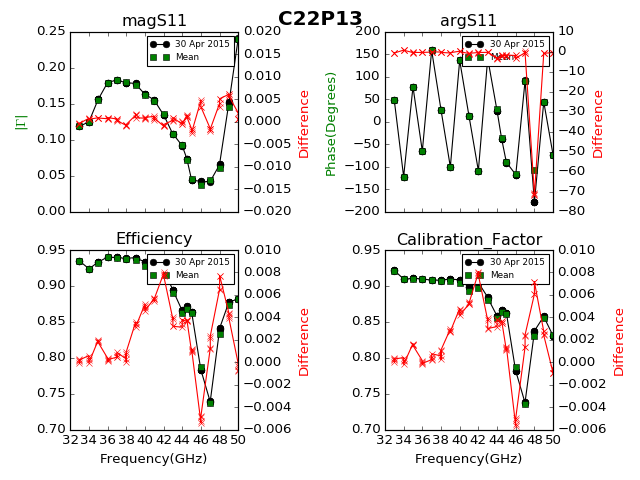

It took 0.757 seconds to process


In [127]:
#input_file=r"C:\Share\Ck_Std_raw_ascii\C07207.D1_030298"
input_file=r"C:\Share\Ck_Std_raw_ascii\C07207.D9_042500"
#input_file=r"C:\Share\Ck_Std_raw_ascii\C07208.A10_081507"
#input_file=r"C:\Share\Ck_Std_raw_ascii\CTNP20.R1_032310"
#input_file=r"C:\Share\Ck_Std_raw_ascii\CN49.K2_050608"
input_file=r"C:\Share\Ck_Std_raw_ascii\C22P13.H4_043015"
#input_file=r"C:\Share\Ck_Std_raw_ascii\C24N07.L1_070998"


start_time=datetime.datetime.now()
file_model=sparameter_power_type(input_file)
model=globals()[file_model]
table=model(input_file)
#print table
#table.metadata["System_Id"]
options={"Device_Id":table.metadata["Device_Id"], "System_Id":table.metadata["System_Id"],"Measurement_Timestamp":None, 
              "Connector_Type_Measurement":table.metadata["Connector_Type_Measurement"],
             "Measurement_Date":None,"Measurement_Time":None}
if re.search('2-port',table.metadata["Measurement_Type"],re.IGNORECASE) and not re.search('2-portNR',table.metadata["Measurement_Type"],re.IGNORECASE):
    history_key='2-port'
    options["column_names"]=['Frequency','magS11','argS11','magS21','argS21','magS22','argS22']
elif re.search('2-portNR',table.metadata["Measurement_Type"],re.IGNORECASE):
    history_key='2-portNR'
    options["column_names"]=['Frequency','magS11','argS11','magS12','argS12','magS21','argS21','magS22','argS22']
elif re.search('1-port',table.metadata["Measurement_Type"],re.IGNORECASE):
    history_key='1-port'
    options["column_names"]=['Frequency','magS11','argS11','magS22','argS22']
elif re.search('Dry Cal|Thermistor|power',table.metadata["Measurement_Type"],re.IGNORECASE):
    history_key='power'
    options["column_names"]=['Frequency','magS11','argS11','Efficiency','Calibration_Factor']
#print history[history_key][:5]
print history_key
mean_frame=mean_from_history(history_dict[history_key].copy(),**options)
#print mean_frame
difference_frame=raw_difference_frame(table,mean_frame)
#print difference_frame
raw_comparision_plot_with_residuals(table,mean_frame,difference_frame)
stop_time=datetime.datetime.now()
diff=stop_time-start_time
print("It took {0} seconds to process".format(diff.total_seconds()))